In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from qutip import *
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import simpson
from scipy import stats
plt.rcParams.update({'font.size': 14})

In [2]:
def model(z,t,myu,q0):
    omega=1
    x=z[0]
    y=z[1]
    dxdt=omega*y
    dydt=-myu*dxdt*(x**2-q0**2)-omega*x
    dzdt=[dxdt,dydt]
    return dzdt
def coper(N,q0,myu):
    cops=[]
    a=destroy(N)
    adag=a.dag()
    zeta=myu/12
    beta=myu/24
    eta=myu*(q0**2-1)/4
    const1=myu*(q0**2-1)
    const2=3*myu/4
    c1=sqrt(const1)*adag
    c2=sqrt(const2)*a**2
    c3=sqrt(myu)*(adag*a-0.5*adag**2)
    cops.append(c1)
    cops.append(c2)
    cops.append(c3)
    return cops
def hamil(N,omega,q0,myu):
    a=destroy(N)
    adag=a.dag()
    zeta=myu/12
    beta=myu/24
    eta=myu*(q0**2-1)/4
    H=omega*adag*a+(1j*zeta*(adag*a**3-(adag**3)*a))+(1j*beta*(a**4-adag**4))-(1j*eta*(a**2-adag**2))
    return H
def retdiag(rho,N):
    rhoii=[]
    n=[]
    for i in range(N):
        rhoii.append(rho.diag())
        n.append(i+1)
    return n,rhoii
def retdens(H,cops,N):
    expop=rand_dm(N)
    times = np.linspace(0.0, 100.0, 10000)
    result_dm = mesolve(H, expop, times, cops)
    return result_dm.states    
def Gauss(x, A, B, C):
    y = A*np.exp(-((x-B)/C)**2)
    return y
def expdecay(x,lam,A,C):
    y=A*np.exp(-lam*(x-C))
    return y
def linfit(x,lam,C):
    y=lam*x+C
    return y
def sinfreq(x,A,omega,phi):
    y=A*np.sin(omega*x+phi)
    return y
def eig(myu,qo,omega):
    e=[((myu*q0**2)+1j*sqrt(4*omega**2-(myu**2)*q0**4))/2,((myu*q0**2)-1j*sqrt(4*omega**2-(myu**2)*q0**4))/2]
    return e
def retindex(tl,period):
    index2=0
    t2=0
    t2=tl[0]+abs(period)
    epi=0.01
    for i in range(len(tl)):
        if tl[i]<=(t2+epi) and tl[i]>=(t2-epi):
            index2=i
    return index2
def jacob(omega,q0,myu,q,p):
    j=np.zeros((2,2))
    j[0][0]=0
    j[0][1]=omega
    j[1][0]=-2*myu*q*p-omega
    j[1][1]=-myu*(q**2-q0**2)
    return j
def floquet(omega,q0,myu,position,momentum,times,T):
    final=np.identity(2)
    I=np.identity(2)
    for i in range(len(times)):
        q=position[i]
        p=momentum[i]
        final=final*(I+(T/len(times))*(jacob(omega,q0,myu,q,p)))
    return final
def square(list):
    return [i ** 2 for i in list]
def frobenius(A,B):
    C=A-B
    return sqrt((C*C.dag()).tr())
    
    

In [3]:
q0=3
omega=1
N=30
x=np.linspace(-8,+8,200)
p=np.linspace(-8,+8,200)

In [4]:
myu=[0.001,0.009,0.03,0.05,0.07,0.1]
H=[]
cops=[]
ss=[]

In [5]:
for i in range(len(myu)):
    m=myu[i]
    h=hamil(N,omega,q0,m)
    c=coper(N,q0,m)
    s=steadystate(h,c)
    H.append(h)
    cops.append(c)
    ss.append(s)

In [40]:
dm1=retdens(H[0],cops[0],N)
frob=[]
times = np.linspace(0.0, 4000.0, 10000)
for i in range(len(dm1)):
    frob.append(frobenius(dm1[i],ss[0]))

Text(0.5, 1.0, '$For$ $\\mu$ $=$ $0.001$')

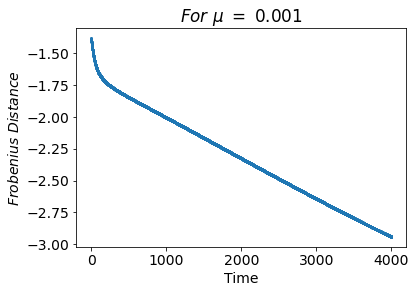

In [42]:
plt.scatter(times[0:],np.log(frob[0:]),s=3)
plt.ylabel(r'$Frobenius$ $Distance$')
plt.xlabel('Time')
plt.tight_layout()
plt.title(r'$For$ $\mu$ $=$ $0.001$')

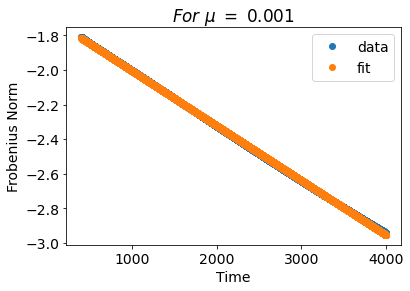

In [43]:
t1=1000
guess=np.random.rand(2)
parameters1, covariance1 = curve_fit(linfit, times[t1:],np.log(frob[t1:]),p0=guess)
fit_A = parameters1[0]
fit_B = parameters1[1]
#fit_y = expdecay(times, fit_A,fit_B)
fit_y=linfit(times[t1:],fit_A,fit_B)
plt.plot(times[t1:],np.log(frob[t1:]), 'o', label='data')
plt.plot(times[t1:], fit_y, 'o', label='fit')
plt.ylabel('Frobenius Norm')
plt.xlabel('Time')
plt.title(r'$For$ $\mu$ $=$ $0.001$')
#plt.savefig("fitlog1mfid0.001.png")
plt.legend()

In [44]:
lamb=np.zeros(6)
lamb[0]=fit_A

In [45]:
dm2=retdens(H[1],cops[1],N)
frob=[]
for i in range(len(dm2)):
    frob.append(frobenius(dm2[i],ss[1]))

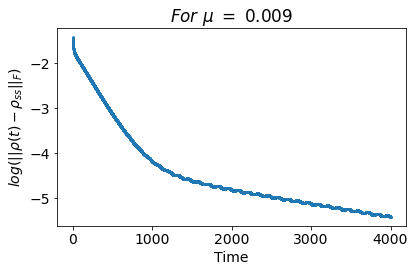

In [16]:
plt.scatter(times,np.log(frob),s=3)
plt.ylabel(r'$log(||\rho(t)-\rho_{ss}||_F)$')
plt.xlabel('Time')
plt.title(r'$For$ $\mu$ $=$ $0.009$')
plt.tight_layout()
#plt.savefig('logfrobdist0.009.png')

Text(0.5, 1.0, '$For$ $\\mu$ $=$ $0.009$')

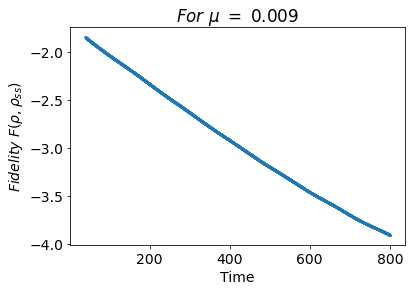

In [48]:
plt.scatter(times[100:2000],np.log(frob[100:2000]),s=3)
plt.ylabel(r'$Fidelity$ $F(\rho,\rho_{ss})$')
plt.xlabel('Time')
plt.title(r'$For$ $\mu$ $=$ $0.009$')

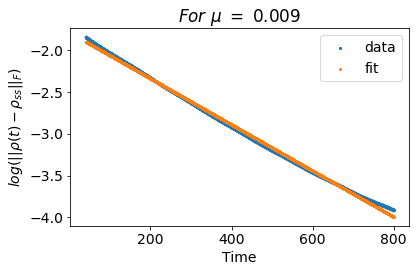

In [49]:
t1=100
t2=2000
guess=np.random.rand(2)
parameters1, covariance1 = curve_fit(linfit, times[t1:t2],np.log(frob[t1:t2]),p0=guess)
fit_A = parameters1[0]
fit_B = parameters1[1]
#fit_y = expdecay(times, fit_A,fit_B)
fit_y=linfit(times[t1:t2],fit_A,fit_B)
plt.scatter(times[t1:t2],np.log(frob[t1:t2]), label='data',s=5)
plt.scatter(times[t1:t2], fit_y, label='fit',s=4)
plt.ylabel(r'$log(||\rho(t)-\rho_{ss}||_F)$')
plt.xlabel('Time')
plt.title(r'$For$ $\mu$ $=$ $0.009$')
plt.legend()
plt.tight_layout()
#plt.savefig("fitlogfrob0.009.png")


In [50]:
lamb[1]=fit_A

In [51]:
lamb

array([-0.00031577, -0.00275443,  0.        ,  0.        ,  0.        ,
        0.        ])

In [74]:
dm3=retdens(H[2],cops[2],N)
frob=[]
for i in range(len(dm3)):
    frob.append(frobenius(dm3[i],ss[2]))


Text(0.5, 1.0, '$For$ $\\mu$ $=$ $0.03$')

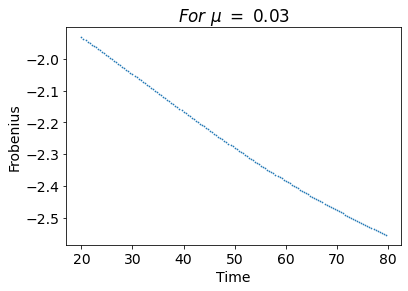

In [80]:
plt.scatter(times[50:200],np.log(frob[50:200]),s=0.5)
plt.ylabel(r'Frobenius')
plt.xlabel('Time')
plt.title(r'$For$ $\mu$ $=$ $0.03$')

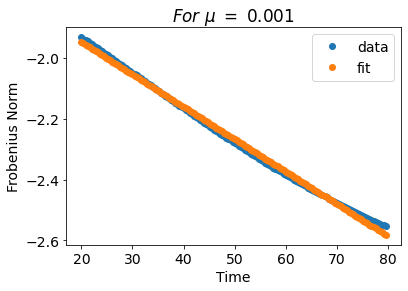

In [81]:
t1=50
t2=200
guess=np.random.rand(2)
parameters1, covariance1 = curve_fit(linfit, times[t1:t2],np.log(frob[t1:t2]),p0=guess)
fit_A = parameters1[0]
fit_B = parameters1[1]
#fit_y = expdecay(times, fit_A,fit_B)
fit_y=linfit(times[t1:t2],fit_A,fit_B)
plt.plot(times[t1:t2],np.log(frob[t1:t2]), 'o', label='data')
plt.plot(times[t1:t2], fit_y, 'o', label='fit')
plt.ylabel('Frobenius Norm')
plt.xlabel('Time')
plt.title(r'$For$ $\mu$ $=$ $0.001$')
#plt.savefig("fitlog1mfid0.001.png")
plt.legend()

In [82]:
lamb[2]=fit_A

In [60]:
dm4=retdens(H[3],cops[3],N)
frob=[]

for i in range(len(dm4)):
    frob.append(frobenius(dm4[i],ss[3]))


Text(0.5, 1.0, '$For$ $\\mu$ $=$ $0.005$')

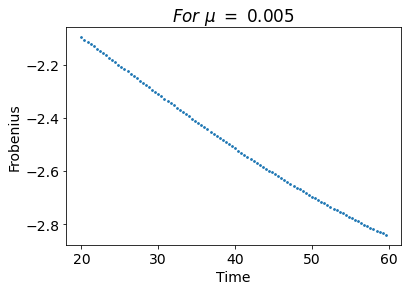

In [61]:
plt.scatter(times[50:150],np.log(frob[50:150]),s=3)
plt.ylabel(r'Frobenius')
plt.xlabel('Time')
plt.title(r'$For$ $\mu$ $=$ $0.005$')

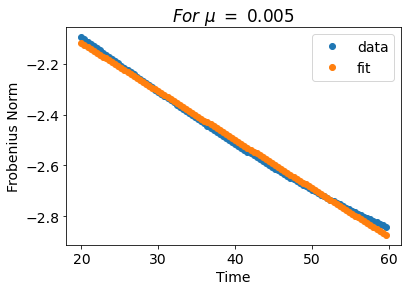

In [62]:
t1=50
t2=150
guess=np.random.rand(2)
parameters1, covariance1 = curve_fit(linfit, times[t1:t2],np.log(frob[t1:t2]),p0=guess)
fit_A = parameters1[0]
fit_B = parameters1[1]
#fit_y = expdecay(times, fit_A,fit_B)
fit_y=linfit(times[t1:t2],fit_A,fit_B)
plt.plot(times[t1:t2],np.log(frob[t1:t2]), 'o', label='data')
plt.plot(times[t1:t2], fit_y, 'o', label='fit')
plt.ylabel('Frobenius Norm')
plt.xlabel('Time')
plt.title(r'$For$ $\mu$ $=$ $0.005$')
#plt.savefig("fitlog1mfid0.001.png")
plt.legend()

In [63]:
lamb[3]=fit_A

In [29]:
myu

[0.001, 0.009, 0.03, 0.05, 0.07, 0.1]

In [64]:
dm4=retdens(H[4],cops[4],N)
frob=[]

for i in range(len(dm4)):
    frob.append(frobenius(dm4[i],ss[4]))


Text(0.5, 1.0, '$For$ $\\mu$ $=$ $0.007$')

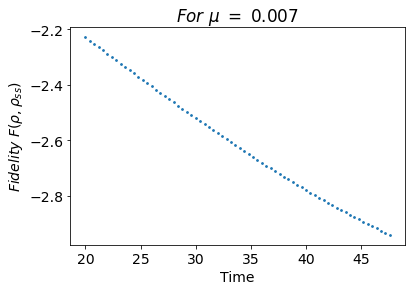

In [65]:
plt.scatter(times[50:120],np.log(frob[50:120]),s=3)
plt.ylabel(r'$Fidelity$ $F(\rho,\rho_{ss})$')
plt.xlabel('Time')
plt.title(r'$For$ $\mu$ $=$ $0.007$')

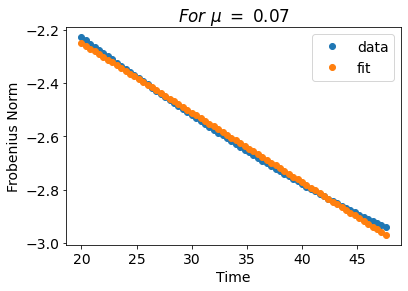

In [66]:
t1=50
t2=120
guess=np.random.rand(2)
parameters1, covariance1 = curve_fit(linfit, times[t1:t2],np.log(frob[t1:t2]),p0=guess)
fit_A = parameters1[0]
fit_B = parameters1[1]
#fit_y = expdecay(times, fit_A,fit_B)
fit_y=linfit(times[t1:t2],fit_A,fit_B)
plt.plot(times[t1:t2],np.log(frob[t1:t2]), 'o', label='data')
plt.plot(times[t1:t2], fit_y, 'o', label='fit')
plt.ylabel('Frobenius Norm')
plt.xlabel('Time')
plt.title(r'$For$ $\mu$ $=$ $0.07$')
#plt.savefig("fitlog1mfid0.001.png")
plt.legend()

In [67]:
lamb[4]=fit_A

In [68]:
dm6=retdens(H[5],cops[5],N)
frob=[]
for i in range(len(dm6)):
    frob.append(frobenius(dm6[i],ss[5]))


Text(0.5, 1.0, '$For$ $\\mu$ $=$ $0.1$')

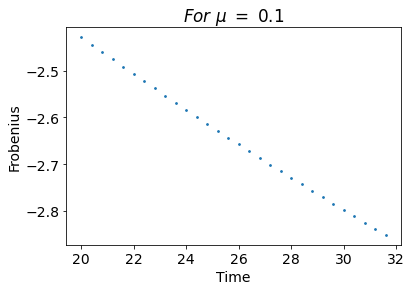

In [70]:
plt.scatter(times[50:80],np.log(frob[50:80]),s=3)
plt.ylabel(r'Frobenius')
plt.xlabel('Time')
plt.title(r'$For$ $\mu$ $=$ $0.1$')

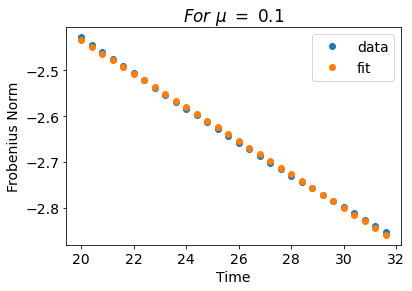

In [71]:
t1=50
t2=80
guess=np.random.rand(2)
parameters1, covariance1 = curve_fit(linfit, times[t1:t2],np.log(frob[t1:t2]),p0=guess)
fit_A = parameters1[0]
fit_B = parameters1[1]
#fit_y = expdecay(times, fit_A,fit_B)
fit_y=linfit(times[t1:t2],fit_A,fit_B)
plt.plot(times[t1:t2],np.log(frob[t1:t2]), 'o', label='data')
plt.plot(times[t1:t2], fit_y, 'o', label='fit')
plt.ylabel('Frobenius Norm')
plt.xlabel('Time')
plt.title(r'$For$ $\mu$ $=$ $0.1$')
#plt.savefig("fitlog1mfid0.001.png")
plt.legend()

In [72]:
lamb[5]=fit_A

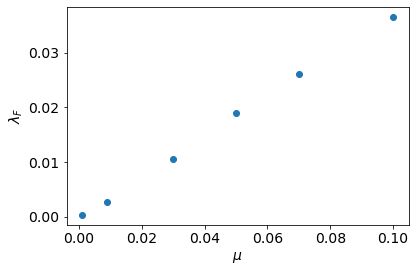

In [84]:
plt.scatter(myu,np.abs(lamb))
plt.ylabel(r'$\lambda_F$')
plt.xlabel(r'$\mu$')
plt.tight_layout()
plt.savefig('frobmyu.png')

In [85]:
flexp=[-0.0035339617294815277,
 -0.07812232131595394,
 -0.27245448225588853,
 -0.4593171640883984,
 -0.6509590318546369,
 -0.9599822867872988]

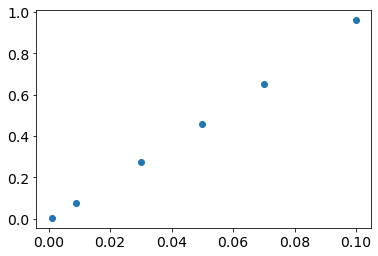

In [86]:
plt.scatter(myu,np.abs(flexp))

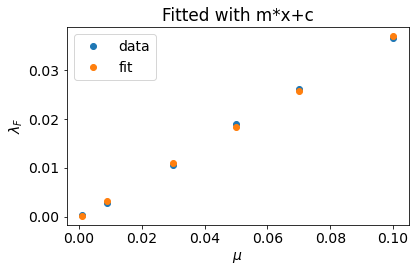

In [87]:
guess=np.random.rand(2)
parameters1, covariance1 = curve_fit(linfit, myu, np.abs(lamb),p0=guess)
fit_A = parameters1[0]
fit_B = parameters1[1]
fit_y=linfit(np.asarray(myu),fit_A,fit_B)
plt.plot (myu, np.abs(lamb), 'o', label='data')
plt.plot(myu, fit_y, 'o', label='fit')
plt.legend()
plt.ylabel(r'$\lambda_F$')
plt.xlabel(r'$\mu$')
plt.title('Fitted with m*x+c')
plt.tight_layout()
plt.savefig('frobmyufit.png')

In [88]:
m1=fit_A

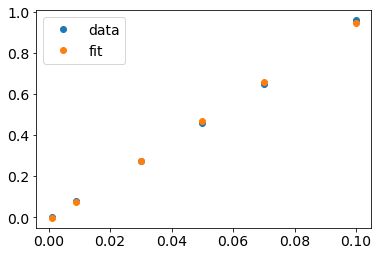

In [90]:
guess=np.random.rand(2)
parameters1, covariance1 = curve_fit(linfit, myu, np.abs(flexp),p0=guess)
fit_A = parameters1[0]
fit_B = parameters1[1]
fit_y=linfit(np.asarray(myu),fit_A,fit_B)
plt.plot (myu, np.abs(flexp), 'o', label='data')
plt.plot(myu, fit_y, 'o', label='fit')
plt.legend()

In [91]:
m2=fit_A

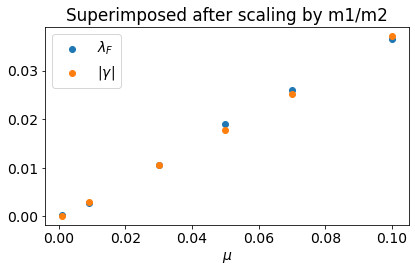

In [92]:
plt.scatter(myu,np.abs(lamb),label=r'$\lambda_F$')
plt.scatter(myu,(m1/m2)*np.asarray(np.abs(flexp)),label=r'$|\gamma|$')
plt.legend()
plt.xlabel(r'$\mu$')
plt.title('Superimposed after scaling by m1/m2')
plt.tight_layout()
plt.savefig('frobmyufloquet.png')

In [93]:
m1/m2

0.03866840951300816